In [163]:
import json
import os
import pickle
import psycopg2
import sqlalchemy
import pyproj
import sys
sys.path.append("..")

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import seaborn as sns
from shapely.geometry import Point
get_ipython().magic(u'matplotlib inline')
%matplotlib inline

from connect_db import db_connection

# filter annyoing warning from pandas
import warnings
warnings.filterwarnings('ignore')

In [2]:
username='bdelpapa'

In [3]:
cred_location = '/mnt/data/'+username+'/TPT_tourism/connect_db/data_creds.json.nogit'
db = db_connection.DBConnection(cred_location)

In [227]:
# Load maps data 

# load data from TPT
regions = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/Reg2016_WGS84_g/Reg_2016_WGS84_g.shp"
provinces = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/CMProv2016_WGS84_g/CMprov2016_WGS84_g.shp"
municipalities = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/Com2016_WGS84_g/Com2016_WGS84_g.shp"
new_reg =  r"/mnt/data/shared/ITA_shapefiles/Tus_28districts.shp"

# important cities 
important_cities_file = r"/mnt/data/shared/important_cities.csv"

In [230]:
# Select only Tuscany

df_reg = gpd.read_file(regions)
df_pro = gpd.read_file(provinces)
df_mun = gpd.read_file(municipalities)
df_newreg = gpd.read_file(new_reg)
important_cities = pd.read_csv(important_cities_file)

df_reg_tusc = df_reg[df_reg["COD_REG"] == 9] # tuscany
df_pro_tusc = df_pro[df_pro["COD_REG"] == 9]
df_mun_tusc = df_mun[df_mun["COD_REG"] == 9]

# Convert coordinates in WGS84 to Lat Lon format (DO NOT use for the _github files)
# see http://geopandas.org/projections.html
df_reg_tusc['geometry'] = df_reg_tusc['geometry'].to_crs(epsg=4326)
df_pro_tusc['geometry'] = df_pro_tusc['geometry'].to_crs(epsg=4326)
df_mun_tusc['geometry'] = df_mun_tusc['geometry'].to_crs(epsg=4326)

In [6]:
# Helper functions for calculating Point counts

def heatmap_calculate(df_coords, df_map, new_field_header='Point_counts'):
    '''
    Calculate the density of points for the heatmap
    Adds the field 'Point_counts' to df_map, containing the Point counts for each municipality
    TODO: write a prettier and faster loop
    
    Params:
        df_coords: DataFrame with 'lat' and 'lon' fields
        df_map: DataFrame with 'geometry' field
        new_field_header: str with name of the new field to be created in df_map
    '''
    
    locs = [Point(xy) for xy in zip(df_coords.lon, df_coords.lat)] 
    df_map[new_field_header] = 0 # counts for each municipality 

    # this is still very slow... (10 min for 100000 points)
    for index, municipality in df_map.iterrows():

        counts = 0
        for i, loc in enumerate(locs):
            if loc.within(municipality['geometry']):
                counts += df_coords.at[index, 'count']             # add count to municipality
              # locs.pop(i)              # this does not work... also, there must be a faster way 
            
        df_map.at[index, new_field_header] = counts

In [101]:
# Helper functions for and ploting heatmaps

def heatmap_plot(df_map, header='Point_counts', colorbar=True):
    '''
    Plot the Point counts heatmap per municipality
    TODO: fix colorbar
    
    Params:
        df_map: DataFrame with the 'Point_counts' field
        header: str with the name of the field to be ploted
        colorbar: bool, include a colorbar in the plot
    '''
    
    # include log column
    header_log = 'log_'+header
    df_map[header_log] = np.log(df_map[header])
    
    # plot
    ax = df_map.plot(column=header_log, cmap='Reds', edgecolor='gray', figsize=(10, 10), alpha=0.6)
    
    if colorbar:
        # colorbar blackmagic    
        norm = Normalize(vmin=df_map[header_log].min(), vmax=df_map[header_log].max())
        n_cmap = cm.ScalarMappable(norm=norm, cmap='Reds')
        n_cmap.set_array([])
        cbar = ax.get_figure().colorbar(n_cmap, 
                                        ticks = np.arange(df_map[header_log].min(), df_map[header_log].max()), 
                                        fraction=0.03)
        cbar.ax.set_yticklabels(np.exp(np.arange(df_map[header_log].min(), df_map[header_log].max())).astype(int))
        cbar.ax.set_ylabel('Point counts', rotation=270, labelpad=25, fontsize=15)

In [8]:
# run the query for the vodafone data (takes some time)
# TODO: In the future, this query will alread calculate the counts for the heatmap

query = """
with loc_density as (

select cur_loc,count(distinct(customer_id)) 
from tpt.tuscany_test.vodafone_trunc
group by cur_loc

)

select tpt.tuscany_test.location.lon ,tpt.tuscany_test.location.lat ,loc_density.count from loc_density
inner join tpt.tuscany_test.location on cur_loc = location_id
order by count desc;
"""
df_vodafone = db.sql_query_to_data_frame(query)

In [246]:
# calculate heatmap for tuscany (the Point_counts_)
heatmap_calculate(df_vodafone, df_pro_tusc)
heatmap_calculate(df_vodafone, df_reg_tusc)
heatmap_calculate(df_vodafone, df_mun_tusc)
heatmap_calculate(df_vodafone, df_newreg)

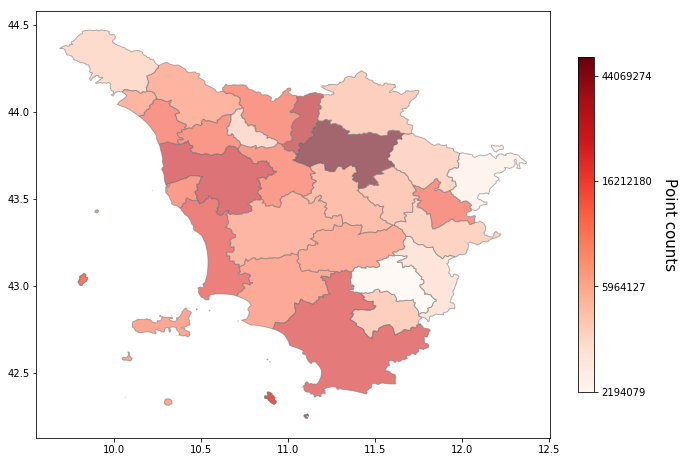

In [250]:
df_newreg.Point_counts.min()
heatmap_plot(df_newreg, header='Point_counts')

In [226]:
# This query give a more precise count (use with caution, this takes up to 25 minutes!!)

query = """
with cus_loc as (
select customer_id,tuscany_test.location.geom as cus_geom 
from tuscany_test.vodafone_trunc
join tuscany_test.location on cur_loc = location_id
)

select count(distinct cus_loc.customer_id),tuscany_test.com2016_wgs84_g.pro_com,tuscany_test.com2016_wgs84_g.cod_pro
from cus_loc
join tuscany_test.com2016_wgs84_g
on ST_Intersects(cus_loc.cus_geom,(tuscany_test.com2016_wgs84_g.wkb_geometry))
group by tuscany_test.com2016_wgs84_g.pro_com,tuscany_test.com2016_wgs84_g.cod_pro
"""
df_vodafone_direct = db.sql_query_to_data_frame(query)
df_mun_tusc_direct = df_mun_tusc.merge(df_vodafone_direct, how = 'inner', left_on='PRO_COM', right_on='pro_com')

In [11]:
query="""
select pro_com, st_astext(wkb_geometry)
from tuscany_test.com2016_wgs84_g
"""
df_multip = db.sql_query_to_data_frame(query)

geometry = df_multip['wktcolumn'].map(shapely.wkt.loads)
df_multp_gpd = gpd.GeoDataFrame(df_multip, geometry=st_astext)
df_multp_gpd.head()

OperationalError: (psycopg2.OperationalError) FATAL:  password authentication failed for user "dbu"
FATAL:  password authentication failed for user "dbu"
 (Background on this error at: http://sqlalche.me/e/e3q8)

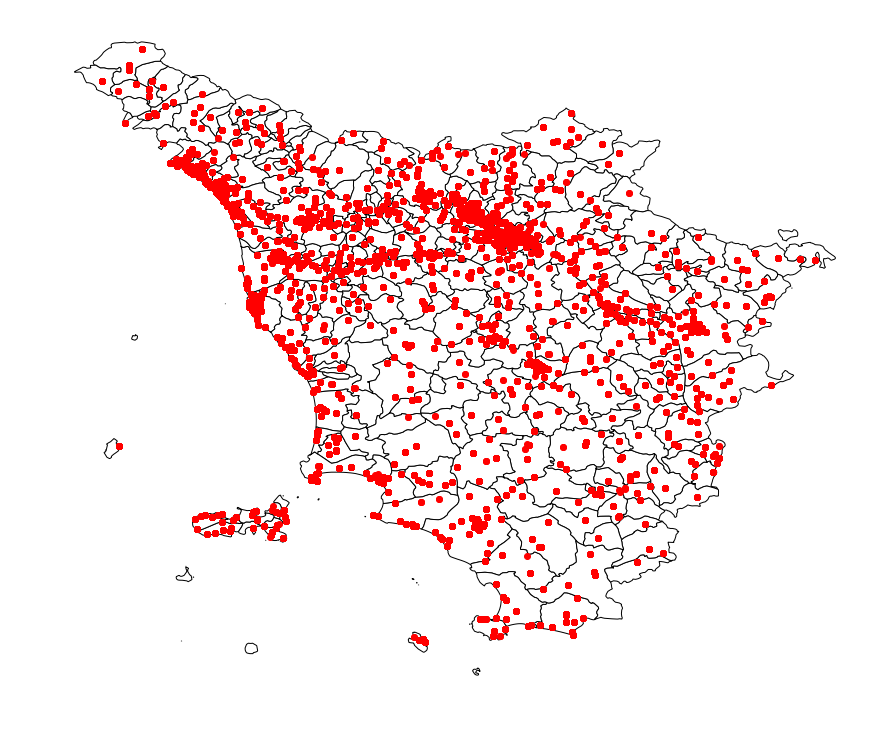

In [96]:
# Plot the towers the vodafone dataset for visualization

df_mun_tusc.plot(color='white', edgecolor='k', figsize=(15, 15), alpha=1) # only borders
plt.plot(df_vodafone.lon, df_vodafone.lat, 'o', color='r')
plt.axis('off')
plt.show()

In [251]:
# plot heatmap

# replace zeros with the minimum positive count
# there are 7 municipalities with 0 towers:
# Capolona, Molazzana, Sassetta, Casale Maritimo, Guardistallo, Filattiera, Tresana
min_Point_count = np.array(df_mun_tusc_direct['Point_counts'])
df_mun_tusc.loc[df_mun_tusc['Point_counts']==0, 'Point_counts'] = np.min(min_Point_count[np.nonzero(min_Point_count)])

#df_mun_tusc_merged.plot(column='count')
heatmap_plot(df_mun_tusc, header='Point_counts')

# plot important cities
for i, name in enumerate(list(important_cities.city)):
    plt.plot(important_cities.long[i], important_cities.lat[i], 'o', color='k', markersize=6)
    plt.annotate(name, (important_cities.long[i]+0.03, important_cities.lat[i]),
                 fontsize=15)

plt.axis('off')
plt.show()

KeyError: 'Point_counts'

In [87]:
# load route files

# load sample random routes
sample_routes_file = r"/mnt/data/shared/customer_ids_for_data_stories.csv"
sample_routes_one_day_file = r"/mnt/data/shared/customer_ids_for_data_stories_one_day_tripeers.csv"
df_sample_routes = pd.read_csv(sample_routes_file)
df_sample_routes_oneday = pd.read_csv(sample_routes_one_day_file) 
df_routes = pd.concat([df_sample_routes_oneday, df_sample_routes]) # concat in one
df_routes.index = range(0, len(df_routes))                         # change index

In [88]:
# run queries for trajectories, for each of the 80 sample random routes

queries = []
df_single_customers = []
for i in range(80):
    customer_id = df_routes.loc[i, 'customer_id']
    
    # query to retrieve lat lon based on custumer id
    query = """
   
    select tpt.tuscany_test.location.lat,  tpt.tuscany_test.location.lon
    from tpt.tuscany_test.vodafone_trunc
    inner join tpt.tuscany_test.location on tpt.tuscany_test.vodafone_trunc.cur_loc = tpt.tuscany_test.location.location_id
    where customer_id = '"""+str(customer_id)+"""'
    order by tpt.tuscany_test.vodafone_trunc.cur_time_stamp
    """
    queries.append(query)
    df_single_customer = db.sql_query_to_data_frame(query)    
    df_single_customers.append(df_single_customer)

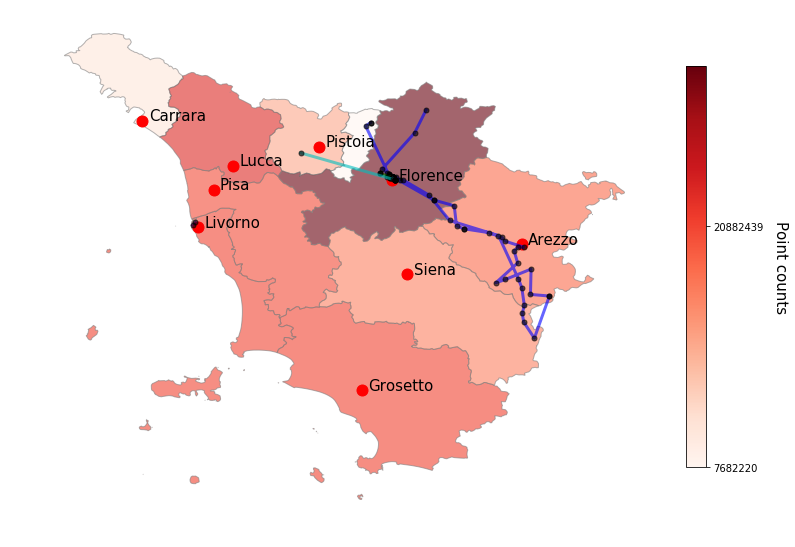

In [90]:
# Plot map with trajectories (example)
day_trips = [0, 24]
long_weekends = [24, 3*24]
vacation = [3*24, 7*24]

heatmap_plot(df_pro_tusc)
#df_tusc.plot(color='white', edgecolor='gray', figsize=(15, 15), alpha=1) # only borders

# plot important cities
for i, name in enumerate(list(important_cities.city)):
    plt.plot(important_cities.long[i], important_cities.lat[i], 'o', color='r', markersize=11)
    plt.annotate(name, (important_cities.long[i]+0.03, important_cities.lat[i]),
                 fontsize=15)        

from cycler import cycler
#plt.rc('axes', prop_cycle=(cycler('color', ['orange', 'g', 'b'])))
plt.rc('axes', prop_cycle=(cycler(color='bgcmyk')))
for i in reversed(range(80)):
    # plot
    if day_trips[0] < df_routes.loc[i, 'hours'] <= day_trips[1]:
        plt.plot(df_single_customers[i].lon, df_single_customers[i].lat, '-', linewidth=3, alpha=0.6)
        plt.plot(df_single_customers[i].lon, df_single_customers[i].lat, 'o', color='k', markersize=5, alpha=0.6)     
        
plt.axis('off')
plt.show()

In [91]:
# Query counts per time of the day and day of the week
# TODO: a for loop should take care of all this
query_w_am = """
with loc_density as (

select cur_loc,count(distinct(customer_id)) 
from tpt.tuscany_test.vodafone_trunc
where extract(hour from tpt.tuscany_test.vodafone_trunc.cur_time_stamp) < 12 and
extract(dow from tpt.tuscany_test.vodafone_trunc.cur_time_stamp) < 6 and 
extract(dow from tpt.tuscany_test.vodafone_trunc.cur_time_stamp) > 0 
group by cur_loc

)

select tpt.tuscany_test.location.lon ,tpt.tuscany_test.location.lat ,loc_density.count from loc_density
inner join tpt.tuscany_test.location on cur_loc = location_id
order by count desc;
"""
df_vodafone_w_am = db.sql_query_to_data_frame(query_w_am)

In [92]:
# Query counts per time of the day and day of the week
query_w_pm = """
with loc_density as (

select cur_loc,count(distinct(customer_id)) 
from tpt.tuscany_test.vodafone_trunc
where extract(hour from tpt.tuscany_test.vodafone_trunc.cur_time_stamp) >= 12 and
extract(dow from tpt.tuscany_test.vodafone_trunc.cur_time_stamp) < 6 and 
extract(dow from tpt.tuscany_test.vodafone_trunc.cur_time_stamp) > 0 
group by cur_loc

)

select tpt.tuscany_test.location.lon ,tpt.tuscany_test.location.lat ,loc_density.count from loc_density
inner join tpt.tuscany_test.location on cur_loc = location_id
order by count desc;
"""
df_vodafone_w_pm = db.sql_query_to_data_frame(query_w_pm)

In [93]:
# Query counts per time of the day and day of the week
query_we_am = """
with loc_density as (

select cur_loc,count(distinct(customer_id)) 
from tpt.tuscany_test.vodafone_trunc
where extract(hour from tpt.tuscany_test.vodafone_trunc.cur_time_stamp) < 12 and
(extract(dow from tpt.tuscany_test.vodafone_trunc.cur_time_stamp) = 6 or 
extract(dow from tpt.tuscany_test.vodafone_trunc.cur_time_stamp) = 0) 
group by cur_loc

)

select tpt.tuscany_test.location.lon ,tpt.tuscany_test.location.lat ,loc_density.count from loc_density
inner join tpt.tuscany_test.location on cur_loc = location_id
order by count desc;
"""
df_vodafone_we_am = db.sql_query_to_data_frame(query_we_am)

In [94]:
# Query counts per time of the day and day of the week
query_we_pm = """
with loc_density as (

select cur_loc,count(distinct(customer_id)) 
from tpt.tuscany_test.vodafone_trunc
where extract(hour from tpt.tuscany_test.vodafone_trunc.cur_time_stamp) >= 12 and
(extract(dow from tpt.tuscany_test.vodafone_trunc.cur_time_stamp) = 6 or 
extract(dow from tpt.tuscany_test.vodafone_trunc.cur_time_stamp) = 0) 
group by cur_loc

)

select tpt.tuscany_test.location.lon ,tpt.tuscany_test.location.lat ,loc_density.count from loc_density
inner join tpt.tuscany_test.location on cur_loc = location_id
order by count desc;
"""
df_vodafone_we_pm = db.sql_query_to_data_frame(query_we_pm)

In [95]:
# Plot counts per time of the day and day of the week
heatmap_calculate(df_vodafone_w_am, df_mun_tusc, new_field_header='Points_w_am')
heatmap_calculate(df_vodafone_we_am, df_mun_tusc, new_field_header='Points_we_am')
heatmap_calculate(df_vodafone_w_pm, df_mun_tusc, new_field_header='Points_w_pm')
heatmap_calculate(df_vodafone_we_pm, df_mun_tusc, new_field_header='Points_we_pm')

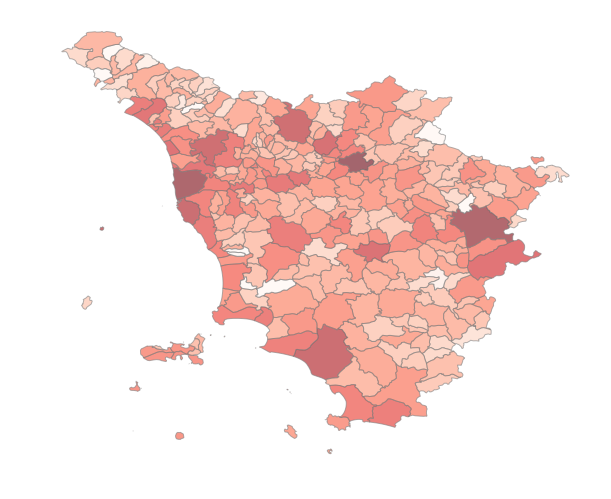

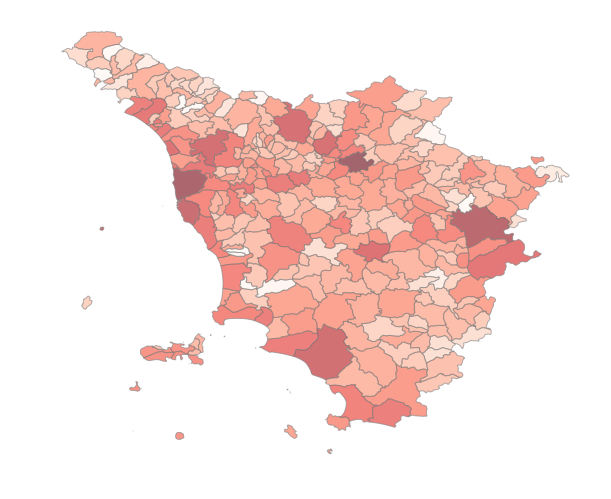

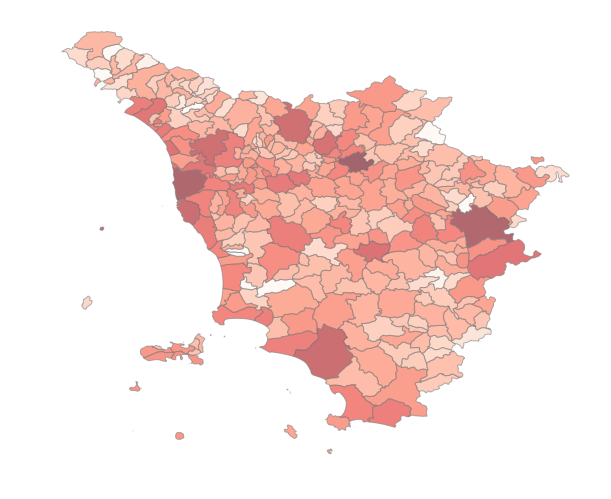

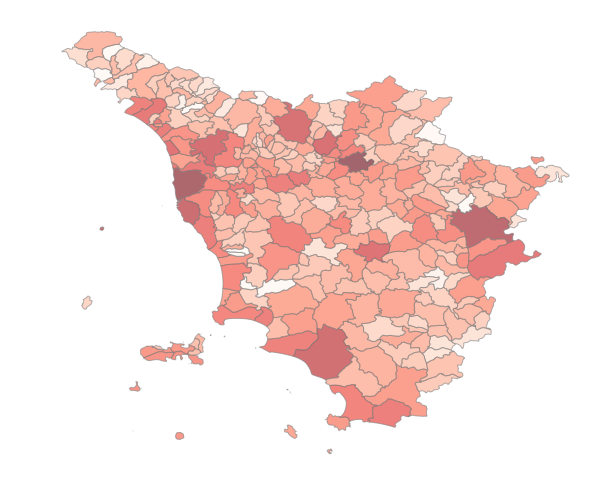

In [225]:
# heatmap subplots am/pm
# TODO: this should be plotted in a grid for better visualization

# replace zeros for minimum positive value
for header in ['Points_w_am', 'Points_we_am', 'Points_w_pm', 'Points_we_pm']:
    min_Point_count = np.array(df_mun_tusc[header])
    df_mun_tusc.loc[df_mun_tusc[header]==0, header] = np.min(min_Point_count[np.nonzero(min_Point_count)])

    
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(15, 15))
heatmap_plot(df_mun_tusc, header='Points_w_am', colorbar=False)
plt.axis('off')
heatmap_plot(df_mun_tusc, header='Points_we_am', colorbar=False)
plt.axis('off')
heatmap_plot(df_mun_tusc, header='Points_w_pm', colorbar=False)
plt.axis('off')
heatmap_plot(df_mun_tusc, header='Points_we_pm', colorbar=False)
plt.axis('off')

plt.show()

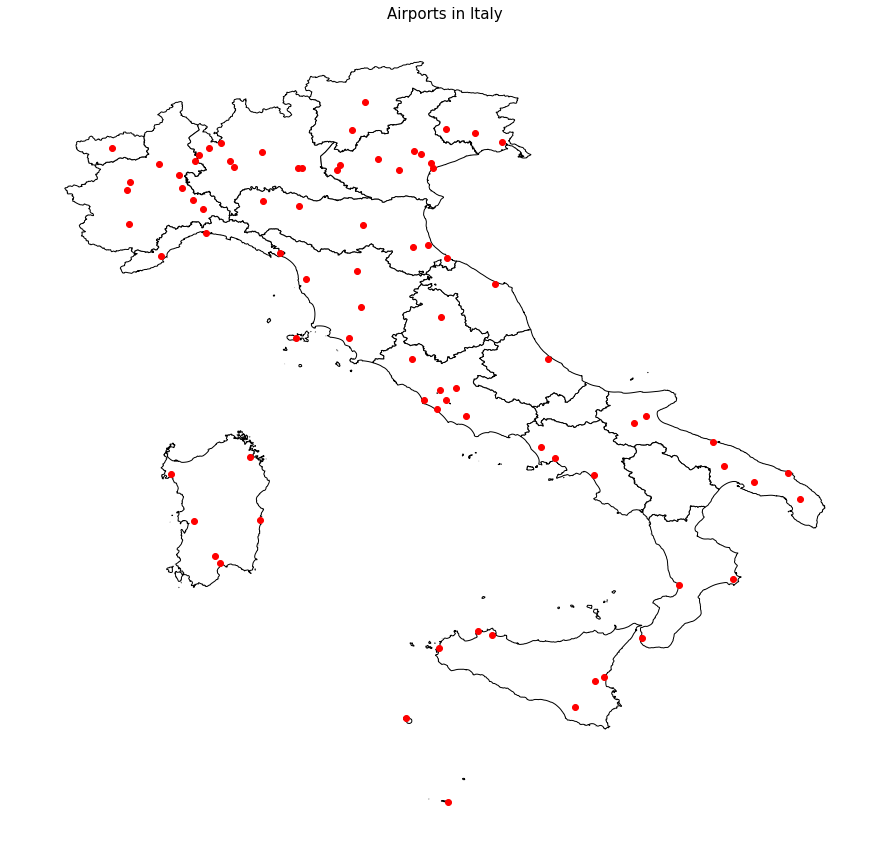

In [117]:
# Airports in Italy

airports = r"/mnt/data/shared/airports.dat"
air_df = pd.read_csv(airports, names = ["Airport ID", 
                                        "Name", 
                                        "City", 
                                        "Country",
                                        "IATA",
                                        "ICAO",
                                        "Lat",
                                        "Lon",
                                        "Alt",
                                        "Timezone",
                                        "DST",
                                        "Tz",
                                        "Type",
                                        "Source"])
air_df = air_df[air_df['Country']=='Italy']

# Plot airports in Italy
df_italy = gpd.read_file(regions)
#df_italy = df_italy[df_italy["COD_REG"] == 9]   # 9 = tuscany
df_italy['geometry'] = df_italy['geometry'].to_crs(epsg=4326)

lats_air = air_df['Lat']
longs_air = air_df['Lon']
locs_air = [Point(xy) for xy in zip(lats_air, longs_air)]

df_italy.plot(color='white', edgecolor='k', figsize=(15, 15), alpha=1) # only borders
plt.plot(longs_air, lats_air, 'o', color='r')
plt.title('Airports in Italy', fontsize=15)

plt.axis('off')
plt.show()

In [126]:
## load roads and rails in tuscany

# rails and roads
rails_file = r"/mnt/data/shared/ITA_shapefiles/ITA_rails.shp"
roads_file = r"/mnt/data/shared/ITA_shapefiles/ITA_roads.shp"

df_roads = gpd.read_file(roads_file)
df_rails = gpd.read_file(rails_file)

In [211]:
# rails and roads in tuscany

tusc_roads = df_roads[df_roads.within(df_reg_tusc['geometry'][8])]
tusc_rails = df_rails[df_rails.within(df_reg_tusc['geometry'][8])]

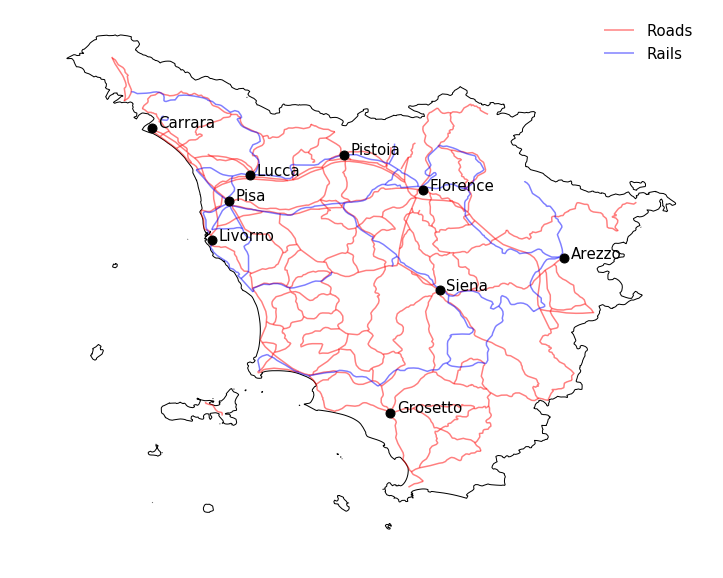

In [222]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1,1,1)

df_reg_tusc.plot(ax=ax,color='w', edgecolor='k')

tusc_roads.plot(ax=ax, color='r', alpha=0.5, label='Roads')
tusc_rails.plot(ax=ax, color='b', alpha=0.5, label='Rails')

# plot important cities
for i, name in enumerate(list(important_cities.city)):
    plt.plot(important_cities.long[i], important_cities.lat[i], 'o', color='k', markersize=9)
    plt.annotate(name, (important_cities.long[i]+0.03, important_cities.lat[i]),
                 fontsize=15) 
    
plt.legend(loc='best', fontsize=15, frameon=False)    
plt.axis('off')
plt.show()